# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers deep learning techniques, namely:
- Variational Graph Normalized Auto-Encoders (based on https://arxiv.org/abs/2108.08046) which allow us to learn graph embeddings in an unsupervised way (based on graph structure and node embeddings)

### 1. Import Packages

In [32]:
from importlib import reload
reload(analyseData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.autoencoder' from '/Users/macbookpro/Desktop/LABS/Network-Science_Final-Project/util/autoencoder.py'>

In [2]:
# import own scripts
import util.analyse_Data as analyseData
#import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [1]:
# parse & handle data
import os
import numpy as np
import pandas as pd

# modeling
import torch
from torch_geometric.nn import GAE, VGAE

# hyperparam optimization
from ray import tune, air

# evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load raw data
node_info, edgelist, class_to_idx_dict, idx_to_class_dict = loadData.load_raw()
G = loadData.init_nx_graph(edgelist)
nodes = set(edgelist.source).union(edgelist.target)
print(nodes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [5]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [79]:
reload(loadData)
(G, G_train, G_trainval, node_info, train, val, test, train_pos_edges, train_neg_edges) = loadData.load()

13
131
0
792
379
655
0
222
469
42
122
1111
1853
114
52
1502
1262
809
1756
102
1706
340
28
578
1334
15
49
1526
1017
1150
102
1605
1251
66
71
656
173
54
122
503
669
906
557
1183
87
119
330
1185
1306
728
1320
1012
1099
84
638
639
446
182
1518
55
84
1200
132
49
701
121
1084
792
42
539
642
786
96
328
188
1587
355
105
784
845
121
513
361
1197
13
241
504
632
750
790
0
248
1044
62
165
15
84
334
906
1155
758
198
877
643
686
72
43
196
198
37
71
508
1298
1190
1291
1133
509
337
1848
121
779
1218
114
537
1677
642
354
0
316
608
331
153
464
561
713
121
0
1241
238
138
952
379
1769
820
66
1053
28
1274
2
71
656
1091
1174
566
121
1096
3
708
233
1502
854
79
424
1286
71
1054
652
772
224
71
291
809
817
182
406
100
177
471
298
237
196
69
249
1758
1410
710
676
188
1336
62
1588
1350
640
525
47
825
657
1544
27
48
922
568
71
84
1016
1562
1447
282
710
52
102
801
74
240
28
452
1349
207
950
557
1039
1161
785
44
771
58
755
87
1038
562
467
192
769
72
173
667
144
76
664
988
755
141
87
2
906
663
266
354
809
1697
1034
4

KeyboardInterrupt: 

In [64]:
test.dtypes

target    object
source    object
y          int64
dtype: object

In [76]:
train_pos_edges['source'].dtype

dtype('int64')

In [44]:
train_neg_edges

,source,target,y
821764,322,2114,0
2512962,1189,1795,0
3158267,1700,2218,0
2323001,1069,1134,0
652737,252,2452,0
...,...,...,...
475819,181,2324,0
1235383,503,519,0
3457508,2062,2628,0
1974895,868,2366,0


In [9]:
# might take up to a minute

data, (G, G_train, G_trainval, node_info, train, val, test) = autoenc.load()


Number of positive edges for training: 3802
Number of positive edges for validation: 1085
Number of positive edges for test: 542
Number of edges in original graph: 5429
Number of edges in training graph: 3802
Create PyTorch Geometric dataset...


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [7]:
# where to save trial results to
ray_path = os.path.abspath("")+"\\ray_results\\"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

### 3. VGNAE Node Embeddings

https://github.com/SeongJinAhn/VGNAE/blob/main/main.py for Variational Graph Normalized Auto-Encoders

#### 3.1 Hyperparameter tuning

In [8]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # log params in raytune
    "ray": True,
    
    # print results per epoch
    "verbose": False,
    
    # basic infos
    "data": data,
    "max_epochs": 50,
    "save": True, # if we want to save best model on validation set
    
    # model
    "model": "VGNAE",
    
    ## encoder
    "enc_channels": 64,
    "scaling": 1.8,
    "num_prop": tune.grid_search([4, 16, 32, 64, 128]),
    "teleport": 0, # tune.grid_search([0, 0.1, 0.2]),
    "dropout": 0, # tune.grid_search([0, 0.1, 0.2]),
    
    # optimizer
    "lr": tune.grid_search([1e-3, 1e-4, 1e-5]),
    "wd": 0,
}

In [ ]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = autoenc.run_ray_experiment(
    autoenc.train_validate, config, ray_path, num_samples,
    metric_columns = ["trn_auc", "val_auc", "max_val_auc", "training_iteration"],
    parameter_columns = ["scaling", "num_prop", "lr"]
)

#### 3.2 Result of Hyperparameter tuning

In [13]:
restored_tuner, result_grid = autoenc.open_validate_ray_experiment(
    "ray_results/train_validate_2023-03-26_14-58-38",
    autoenc.train_validate
)

2023-03-26 15:17:28,656	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


Loading results from ray_results/train_validate_2023-03-26_14-58-38...


2023-03-26 15:17:43,586	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


Done!

No errors! Number of terminated trials: 15


In [14]:
# get best score per trial (highest validation accuracy)
N = 10
best_result_df = result_grid.get_dataframe(
    filter_metric="val_auc", filter_mode="max"
)
best_result_df = best_result_df[["trial_id", "training_iteration", "config/enc_channels",
                                 "config/scaling", "config/num_prop", "config/lr", "config/wd", 
                                 "trn_loss", "val_loss", "trn_auc", "val_auc"]]
best_result_df = best_result_df.sort_values(by=["val_auc"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

,trial_id,training_iteration,config/enc_channels,config/scaling,config/num_prop,config/lr,config/wd,trn_loss,val_loss,trn_auc,val_auc
0,ed048_00000,1,64,1.8,4,0.00100,0,9.786815,5.575768,0.683779,0.715721
1,ed048_00001,1,64,1.8,4,0.00010,0,9.786815,5.575769,0.683779,0.715721
2,ed048_00002,1,64,1.8,4,0.00001,0,9.786815,5.575768,0.683779,0.715721
6,ed048_00006,1,64,1.8,32,0.00100,0,10.026847,5.827116,0.690024,0.715487
7,ed048_00007,1,64,1.8,32,0.00010,0,10.026847,5.827116,0.690024,0.715487
8,ed048_00008,1,64,1.8,32,0.00001,0,10.026847,5.827116,0.690024,0.715487
9,ed048_00009,1,64,1.8,64,0.00100,0,10.026847,5.827116,0.690024,0.715487
10,ed048_00010,1,64,1.8,64,0.00010,0,10.026847,5.827116,0.690024,0.715487
11,ed048_00011,1,64,1.8,64,0.00001,0,10.026847,5.827116,0.690024,0.715487
12,ed048_00012,1,64,1.8,128,0.00100,0,10.026847,5.827116,0.690024,0.715487


#### 3.3 Embeddings based on best model

In [20]:
# load best autoencoder
path = os.path.abspath("")+"\\models\\autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.5, 4, 0, 0))
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [21]:
# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.train_pos_edges)

Text(0.5, 1.0, 'VGNAE projection (first 2 dim) of nodes')

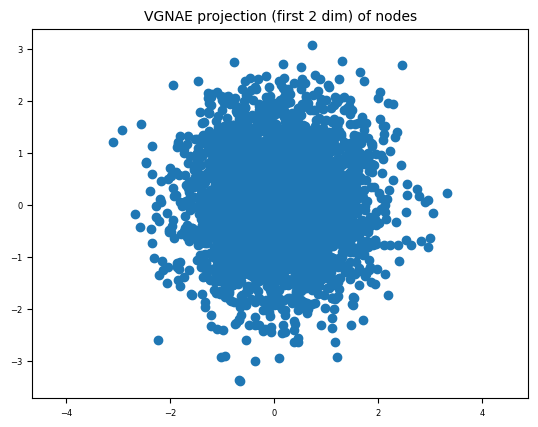

In [22]:
# plot embedding
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('VGNAE projection (first 2 dim) of nodes')

Embeddings look like a sphere, we cannot do any meaningful clusering based on this.

Let us now take our original VGNAE embeddings and put them into a pandas dataframe.

In [23]:
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

node_emb

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64
0,1.075160,0.718271,0.769121,0.775797,-1.279905,-0.976362,-0.094056,-0.198255,1.818417,-1.084478,...,0.070376,0.278775,2.366961,0.341318,0.531096,0.194046,2.475211,1.254946,0.858656,-0.210174
1,-2.172584,0.060929,1.582294,-0.313000,0.922052,-0.540131,0.813517,-0.042542,-1.543304,-1.481937,...,-0.031070,1.563049,-0.885106,0.690414,0.579122,-1.218441,0.047011,0.409482,-1.061487,1.317373
2,-0.050427,0.099830,-0.197430,-0.429610,0.620541,-0.831628,0.589505,0.061404,1.816623,0.507426,...,0.089408,-0.536067,-1.106156,-0.002231,0.797188,1.413167,0.625064,-0.546964,-0.801666,-0.583359
3,-0.793952,-0.682042,-0.480203,-0.502873,1.320457,0.085690,0.736499,-0.901695,-1.689363,0.157804,...,0.887507,-1.128275,-2.220482,0.055625,0.098858,-2.130255,-0.633555,-0.942142,1.420586,0.405759
4,1.305635,-0.372129,-0.875034,-0.056961,-0.573635,-0.222549,-0.016992,1.337109,-0.842328,0.436950,...,-0.472882,0.434661,-0.467042,-1.397569,-0.025545,-1.811786,-0.941567,-1.131787,-0.523205,-1.262454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,0.196942,1.694261,1.406305,0.412216,1.478859,1.014861,0.311998,-0.020339,-0.820678,-0.836831,...,0.202417,0.102025,-1.243950,0.320612,1.269213,-0.338316,0.852789,-1.479115,-0.256058,0.300166
3593,0.961032,-0.902007,0.598484,0.722273,-1.275909,-1.707179,-0.670364,-0.399213,-1.107399,-0.310209,...,1.252496,0.313168,-0.762930,-0.129049,0.160411,-0.118353,1.458129,1.127122,-0.489124,-1.277112
3594,-0.031033,0.361825,0.705179,-0.056923,-0.468499,0.953996,0.397345,-0.305710,-0.294072,0.594690,...,-1.085836,0.148068,0.264693,1.223600,-0.213281,-0.070595,1.178142,0.265681,-3.179762,-0.590819
3595,-0.029846,-1.533631,0.809509,-0.220494,-0.357846,-1.271501,-0.302862,0.956742,-0.648366,0.519814,...,0.169855,0.419474,-3.098811,1.400490,-0.298345,0.081934,0.599173,-1.037998,-0.634847,-0.145510


#### 3.4 Compute edge features based on best model

In [24]:
# predict train
y_train_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges))
y_train_hat = (y_train_hat
    .rename(columns = {0: "sim"})
    .assign(y = trainval_tf.loc[trainval_tf.train_mask == True].y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
print("ROC: ", roc_auc_score(y_train_hat.y, y_train_hat.sim))
print("Acc: ", accuracy_score(y_train_hat.y, y_train_hat.pred))

ROC:  0.7959596351012973
Acc:  0.6838270425226947


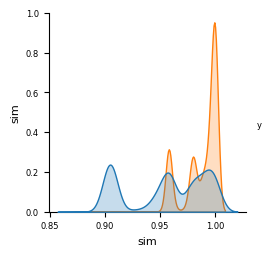

In [25]:
sns.pairplot(y_train_hat[["sim", "y"]], hue = "y")

In [26]:
# predict val
y_val_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges))
y_val_hat = (y_val_hat
    .rename(columns = {0: "sim"})
    .assign(y = trainval_tf.loc[trainval_tf.val_mask == True].y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
print("ROC: ", roc_auc_score(y_val_hat.y, y_val_hat.sim))
print("Acc: ", accuracy_score(y_val_hat.y, y_val_hat.pred))

ROC:  0.7872597361092087
Acc:  0.7157190635451505


In [27]:
tmp = (val_tf
    .assign(sim  = y_val_hat.pred.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

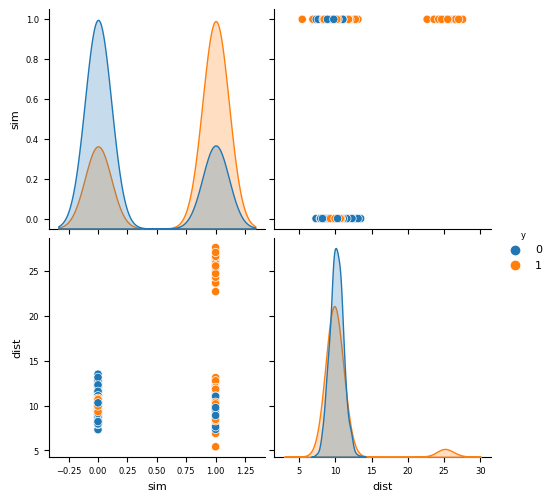

In [28]:
sns.pairplot(tmp[["sim", "dist", "y"]], hue = "y")

In [29]:
tmp.corr()

,node1,node2,y,sim,dist
node1,1.000000,0.493127,0.036595,0.300132,-0.102650
node2,0.493127,1.000000,0.059586,0.347262,-0.107653
y,0.036595,0.059586,1.000000,0.431439,0.095202
sim,0.300132,0.347262,0.431439,1.000000,0.071859
dist,-0.102650,-0.107653,0.095202,0.071859,1.000000


In [30]:
# predict test
y_test_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.trainval_pos_edges, data.test_edges))
y_test_hat = (y_test_hat
    .rename(columns = {0: "sim"})
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
y_test_hat[["pred"]].value_counts()

pred
0       1742
1       1739
dtype: int64